This does this.

In [8]:
import time

import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter


def main():
    BoardShim.enable_dev_board_logger()

    # use synthetic board for demo
    params = BrainFlowInputParams()
    board_id = BoardIds.CYTON_BOARD.value
    params.serial_port = 'COM3'
    board = BoardShim(board_id, params)
    print(board)
    board.prepare_session()
    board.start_stream()
    BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
    time.sleep(10)
    data = board.get_board_data()
    board.stop_stream()
    board.release_session()

    # demo how to convert it to pandas DF and plot data
    eeg_channels = BoardShim.get_eeg_channels(board_id)
    df = pd.DataFrame(np.transpose(data))
    print('Data From the Board')
    print(df.head(10))

    # demo for data serialization using brainflow API, we recommend to use it instead pandas.to_csv()
    DataFilter.write_file(data, 'test.csv', 'w')  # use 'a' for append mode
    restored_data = DataFilter.read_file('test.csv')
    restored_df = pd.DataFrame(np.transpose(restored_data))
    print('Data From the File')
    print(restored_df.head(10))


if __name__ == "__main__":
    main()


BrainFlowError: UNABLE_TO_OPEN_PORT_ERROR:2 unable to prepare streaming session

In [9]:
df = pd.read_csv('BrainFlow-RAW_2025-05-17_14-56-07_0.csv', delimiter='\t', header=None)

In [3]:
import os
from scipy.signal import butter, lfilter, lfilter_zi
import matplotlib.pyplot as plt

'''
Band pass filters with Butterworth filter
Order = 5
Sampling frequency(fs) = 250 Hz
Nyquist frequency(low, high) = 0.5 * fs
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y

sampling_frequency = 250 
# project_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath('nothing.csv'))))
# data_folder = os.path.join(project_path, 'UltraCortex', 'data', '.csv')
# df = pd.read_csv(data_folder)

'''
EEG band pass spectrum:
Delta --> >0.5 Hz and < 4 Hz
Theta --> >4 Hz and < 8 Hz
Alpha --> >8 Hz and < 13 Hz
Beta --> >13 Hz and < 32 Hz
Gamma --> >32 Hz and < 100 Hz
'''
# delta = butter_bandpass_filter(data = df[1], lowcut = 0.5, highcut = 4 , fs = sampling_frequency, order = 3)
# theta = butter_bandpass_filter(data = df[1], lowcut = 4, highcut = 8, fs = sampling_frequency, order = 3)
# alpha = butter_bandpass_filter(data = df[1], lowcut = 8, highcut = 13, fs = sampling_frequency, order = 3)
# beta = butter_bandpass_filter(data = df[1], lowcut = 13, highcut = 32, fs = sampling_frequency, order = 3)
# gamma = butter_bandpass_filter(data = df[1], lowcut = 32, highcut = 100, fs = sampling_frequency, order = 3)

# fig = plt.figure(1)

# fig = plt.figure(1)
# plt.subplot(6,1,1)
# plt.plot(df[1], linewidth=2)
# plt.subplot(6,1,2)
# plt.plot(delta, linewidth=2)
# plt.ylim(-200,200)
# plt.subplot(6,1,3)
# plt.plot(theta, linewidth=2)
# plt.ylim(-200,200)
# plt.subplot(6,1,4)
# plt.plot(alpha, linewidth=2)
# plt.ylim(-200,200)
# plt.subplot(6,1,5)
# plt.plot(beta, linewidth=2)
# plt.ylim(-200,200)
# plt.subplot(6,1,6)
# plt.plot(gamma, linewidth=2)
# plt.ylim(-200,200)
# plt.show()

'\nEEG band pass spectrum:\nDelta --> >0.5 Hz and < 4 Hz\nTheta --> >4 Hz and < 8 Hz\nAlpha --> >8 Hz and < 13 Hz\nBeta --> >13 Hz and < 32 Hz\nGamma --> >32 Hz and < 100 Hz\n'

In [4]:
import seaborn as sns

In [10]:
import seaborn as sns



def plot_all_bands_multi(df, sampling_frequency , xlimlow, xlimhigh, ylimlow, ylimhigh, saveFile='combined_bands.png'):
    sns.set(style="whitegrid")
   
    
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 32),
    }

    # Store band data for all channels
    band_data = {band: [] for band in bands}

    # Apply filters for each channel (assume df columns 1 to 5 are EEG channels)
    for ch in range(1, 8):
        signal = df[ch]
        

        for band_name, (low, high) in bands.items():
            filtered = butter_bandpass_filter(signal, lowcut=low, highcut=high, fs=sampling_frequency, order=3)
            band_data[band_name].append((f'Channel {ch}', filtered))

    # Plotting
    fig, axes = plt.subplots(6, 1, figsize=(12, 14), sharex=True)
    band_names = ['Raw'] + list(bands.keys())

    # Plot raw signal
    for ch in range(1, 8):
        axes[0].plot(df[ch], label=f'Channel {ch}')
    axes[0].set_title('Raw EEG Signals')
    axes[0].legend()

    # Plot each band
    for idx, band_name in enumerate(bands.keys(), start=1):
        for ch_label, ch_data in band_data[band_name]:
            axes[idx].plot(ch_data, label=ch_label)
        axes[idx].set_title(f'{band_name} Band')
        axes[idx].set_ylim(ylimlow, ylimhigh)
        axes[idx].set_xlim(xlimlow,xlimhigh)
        axes[idx].legend(loc='upper right')
            

    plt.tight_layout()
    plt.savefig(saveFile, dpi=300)
    plt.close()

In [11]:
plot_all_bands_multi(df, 300, 500, 1500, -500, 500)

In [5]:


def plot_beta_windows(df, sampling_frequency, window_size, ylimlow, ylimhigh, save_prefix='beta_window'):
    sns.set(style="whitegrid")
    
    beta_low, beta_high = 13, 32
    total_samples = df.shape[0]
    num_channels = min(7, df.shape[1] - 1)  # Channels assumed to be columns 1 to 7

    # Calculate number of windows
    step = window_size
    num_windows = total_samples // step

    for w in range(num_windows):
        start = w * step
        end = start + step
        time = np.arange(start, end) / sampling_frequency

        fig, ax = plt.subplots(figsize=(12, 5))

        # Plot beta-filtered signal for each channel in the current window
        for ch in range(1, num_channels + 1):
            signal = df[ch]
            beta = butter_bandpass_filter(signal, lowcut=beta_low, highcut=beta_high, fs=sampling_frequency, order=3)
            beta_window = beta[start:end]
            ax.plot(time, beta_window, label=f'Channel {ch}')

        ax.set_title(f'Beta Band (13–32 Hz), Time: {start/sampling_frequency:.1f}s–{end/sampling_frequency:.1f}s')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_ylim(ylimlow, ylimhigh)
        ax.legend(loc='upper right')
        ax.grid(True)

        plt.tight_layout()
        plt.savefig(f'{save_prefix}_{w:03d}.png', dpi=300)
        plt.close()


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_beta_windows(df, sampling_frequency, window_size, ylimlow, ylimhigh,
                      save_prefix='beta_window', save_dir='plots'):
    sns.set(style="whitegrid")
    
    beta_low, beta_high = 13, 40
    total_samples = df.shape[0]
    num_channels = min(7, df.shape[1] - 1)  # Channels assumed to be columns 1 to 7

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Calculate number of windows
    step = window_size
    num_windows = total_samples // step

    for w in range(num_windows):
        start = w * step
        end = start + step
        time = np.arange(start, end) / sampling_frequency

        fig, ax = plt.subplots(figsize=(12, 5))

        # Plot beta-filtered signal for each channel in the current window
        for ch in range(1, num_channels + 1):
            signal = df[ch]
            beta = butter_bandpass_filter(signal, lowcut=beta_low, highcut=beta_high, fs=sampling_frequency, order=3)
            beta_window = beta[start:end]
            ax.plot(time, beta_window, label=f'Channel {ch}')

        ax.set_title(f'Beta Band (13–32 Hz), Time: {start/sampling_frequency:.1f}s–{end/sampling_frequency:.1f}s')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_ylim(ylimlow, ylimhigh)
        ax.legend(loc='upper right')
        ax.grid(True)

        plt.tight_layout()
        filename = f"{save_prefix}_{w:03d}.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, dpi=300)
        plt.close()


In [12]:
df = pd.read_csv('BrainFlow-RAW_2025-05-17_20-31-52_2.csv', delimiter='\t', header=None)

In [13]:
plot_beta_windows(df, 300, 1000, -500, 500,'3','plots6')

In [ ]:
df2 =  pd.read_csv('BrainFlow-RAW_2025-05-17_14-56-07_1.csv', delimiter='\t', header=None)

C:\Users\yungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\yungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


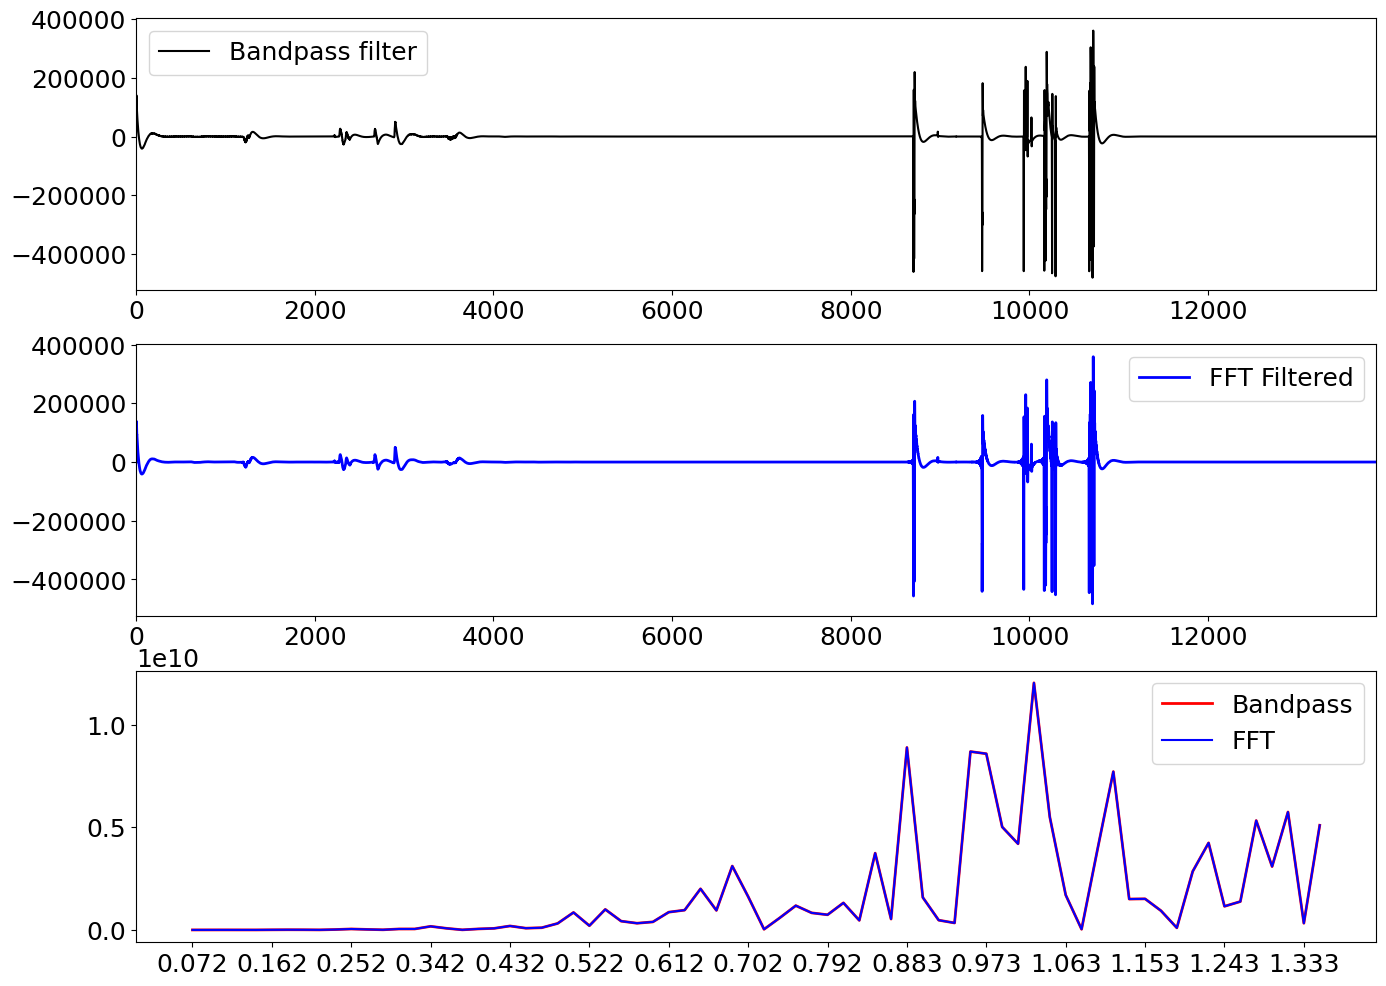

In [18]:
from scipy.signal import butter, lfilter, lfilter_zi, iirnotch, freqz, filtfilt

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 18})


'''
Band pass filters with Butterworth filter
Order = 5
Sampling frequency(fs) = 250 Hz
Nyquist frequency(low, high) = 0.5 * fs
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y



'''
Band pass filters with Butterworth filter
Order = 5
Sampling frequency(fs) = 250 Hz
Nyquist frequency(low, high) = 0.5 * fs
'''

band_pass_eeg = butter_bandpass_filter(data = df[1], lowcut = 1, highcut = 50, fs = 250, order = 3)


'''
Notch filter to remove in-line noise at ~60 Hz (U.S.A)
Process it twice to remove the 60 Hz spike completely
'''
b_notch, a_notch = iirnotch(59.9250936329588, 20, 250)
filtered_eeg = filtfilt(b_notch, a_notch, band_pass_eeg)

b_notch, a_notch = iirnotch(59.9250936329588, 20, 250)
filtered_eeg = filtfilt(b_notch, a_notch, filtered_eeg)


'''
Compute Fourier Coeffecients: Complex calues of Sin and Cosine 
magintude and phase information

Compute Power Spectrum Density: PSD removes noise floor from signal
'''
number_of_points = len(filtered_eeg)
fhat = np.fft.fft(filtered_eeg, number_of_points)
PSD = fhat * np.conj(fhat) / number_of_points
freq = (1/(0.004*number_of_points))*np.arange(number_of_points)
L = np.arange(1,np.floor(number_of_points/2),dtype='int')

'''
Filter frequency based on PSD (>100 threshold)
Inverse Fourier Transform
'''
## Use the PSD to filter out noise
indices = PSD > 100
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat)

'''
Plotting Denoised data
'''
fig,axs = plt.subplots(3,1)
data_points = np.arange(number_of_points)

plt.sca(axs[0])
plt.plot(data_points,band_pass_eeg,color='k',linewidth=1.5,label='Bandpass filter')
plt.xlim(data_points[0],data_points[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(data_points,ffilt,color='b',linewidth=2,label='FFT Filtered')
plt.xlim(data_points[0],data_points[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L][3:75],PSD[L][3:75],color='r',linewidth=2,label='Bandpass')
plt.plot(freq[L][3:75],PSDclean[L][3:75],color='b',linewidth=1.5,label='FFT')
plt.legend()
plt.xticks(freq[L][3:75:5])
plt.show()

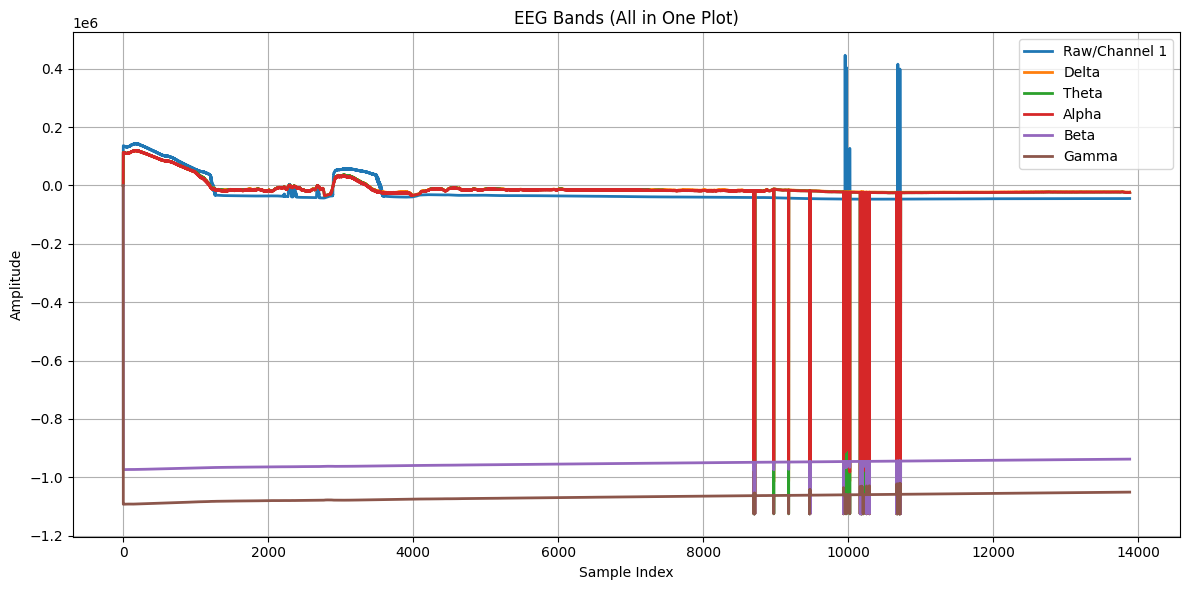

In [ ]:


plt.figure(figsize=(12, 6))

plt.plot(df.iloc[:, 1], label='Raw/Channel 1', linewidth=2)
plt.plot(df.iloc[:, 2], label='Delta', linewidth=2)
plt.plot(df.iloc[:, 3], label='Theta', linewidth=2)
plt.plot(df.iloc[:, 4], label='Alpha', linewidth=2)
plt.plot(df.iloc[:, 5], label='Beta', linewidth=2)
plt.plot(df.iloc[:, 6], label='Gamma', linewidth=2)

plt.title('EEG Bands (All in One Plot)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
